In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Dropout, Input, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

from functools import partial

from albumentations import (Compose, HorizontalFlip, Rotate, OneOf, ToGray, VerticalFlip,
    RandomScale, ChannelShuffle, ChannelDropout, ToSepia, RandomBrightnessContrast
)

import random
import os

from os.path import isfile
import pickle
import lzma

AUTOTUNE = tf.data.experimental.AUTOTUNE


**Постановка задачи**

Совершенно очевидно, что LeNet-5 не хватит глубины для выделения достаточного количества признаков. Ни для Cifar-10, ни тем более для Cifar-100. Особенно если вспомнить, что у LeNet-5 на предпоследнем уровне 84 нейрона.

Аугментация так-же не является чем-то особо интересным или необычным.

В связи с чем мне стало интересно следующее. 
1. Как влияет функция активации на результат.
2. Как влияет аугментация на результат.

Очевидно, что результат будет плачевным, но зато сразу и явно будет заметно влияние манипуляций, что хорошо. Поскольку на том же MNIST чего не делай - ниже 98% результат не получается.

In [62]:
def get_mkl_enabled_flag():
    """The function checks if Intel Tensorflow optimization present"""
    mkl_enabled = False
    major_version = int(tf.__version__.split(".")[0])
    minor_version = int(tf.__version__.split(".")[1])
    if major_version >= 2:
        if minor_version < 5:
            from tensorflow.python import _pywrap_util_port
        else:
            from tensorflow.python.util import _pywrap_util_port
            onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
        mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
    else:
        mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
    return mkl_enabled


print("We are using Tensorflow version", tf.__version__)
print("MKL enabled :", get_mkl_enabled_flag())


We are using Tensorflow version 2.7.0
MKL enabled : True


In [3]:
cifar100_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 
    'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 
    'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 
    'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 
    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 
    'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 
    'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


In [4]:
IMAGE_SHAPE = (32, 32, 3)
AUG_PROBA = lambda x=0: random.uniform(0.35, 0.75)
NUM_EPOCHS = 64
BATCH_SIZE = 256
VAL_BATCH_SIZE = 32
NUM_CLASSES = 10
INITIAL_LR = 0.01

In [5]:
def view_image(ds):
    image, label = next(iter(ds)) 
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(16, 16))

    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        label_idx = np.argmax(label[i], axis=0)
        ax.set_title(f"Label: {cifar100_labels[label_idx]}")


In [63]:
aug_transforms = Compose([
        OneOf([
                Rotate(limit=15, p=AUG_PROBA()),
                Rotate(limit=45, p=AUG_PROBA()),
                Rotate(limit=90, p=AUG_PROBA())
            ], p=AUG_PROBA()),
        OneOf([
                HorizontalFlip(p=AUG_PROBA()),
                VerticalFlip(p=AUG_PROBA())
            ], p=AUG_PROBA()),
        RandomScale(scale_limit=0.05, p=AUG_PROBA()),
    ]
)

Здесь я взял готовый пример из Albumentations и немного его переделал под свои задачи.

Чем интересен именно Tensorflow Dataset. <br>
Намного проще было-бы работать с массивами. Однако массивы совершенно не подходят для работы с большими и очень большими датасетами, поскольку всё загружают в память, которая не резиновая. <br>
Tensorflow же создает итератор, при необходимости с отложенными функциями обработки. И мы проводим обработку и загрузку в память только той части данных, которая нам нужна прямо сейчас. <br>
Это, безусловно, удобно и хорошо оптимизировано под капотом. Но почему при этом нет элементарной функции типа len или shape - загадка. Вероятно Google считает, что ML-щик должен страдать...

In [7]:
def get_dataset(ds_name: str, augment=True):
    def aug_fn(image):
        data = {"image": image}
        aug_data = aug_transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.image.resize(aug_img, size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label

    def normilize_func(image):
        return tf.cast(image/255.0, tf.float32)

    def normilize_data(image, label):
        image = tf.numpy_function(func=normilize_func, inp=[image], Tout=tf.float32)
        return image, tf.one_hot(label, depth=NUM_CLASSES)

    train_ds, test_ds = tfds.load(name=ds_name, split=['train[:85%]','test'], as_supervised=True, with_info=False, shuffle_files=True) 

    if augment:
        train_ds = train_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        
    train_ds = train_ds.map(partial(normilize_data), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    test_ds = test_ds.map(partial(normilize_data), num_parallel_calls=AUTOTUNE).batch(VAL_BATCH_SIZE).prefetch(AUTOTUNE)

    return train_ds, test_ds

Очевидно, что желательно изменять learning rate по мере обучения сети. Это сильно влияет как на сорость обучения, так и на точность модели. <br>
Вариантов тут масса. От стандартной идеи в сторону уменьшения (в совершенно разных вариациях), до циклических. <br> 
Papers на эту тему много. Я взял стандартный экспоненциальный алгоритм. Реализовал через callback, поскольку этот метод позволяет реализовывать совершенно любую фантазию.

In [8]:
# Learning rate exp decay
def lr_exp_decay(epoch, lr):
    k = 0.1
    return INITIAL_LR * np.exp(-k * epoch)


In [9]:
def build_lenet_5(activation_f: str):
    model = Sequential(
        [
            Conv2D(filters=6, kernel_size=(5, 5), activation=activation_f, strides=(1, 1), padding='valid', input_shape=IMAGE_SHAPE),
            AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),

            Conv2D(filters=16, kernel_size=(5, 5), activation=activation_f, strides=(1, 1)),
            AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),

            Flatten(),

            Dense(units=120, activation=activation_f),
            Dense(units=84, activation=activation_f),

            Dense(units=NUM_CLASSES, activation='softmax')
        ]
    )

    adam_optimizer = Adam(learning_rate=INITIAL_LR)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [10]:
def train_model(model_name: str, model=None, train=None, test=None):
    model_history = {}
    model_history_fn = "./data/models/" + model_name + "-history.xz"
    model_fn = './data/models/' + model_name + '-best_model.hdf5'
    ret_model = model

    if isfile(model_history_fn):
        with lzma.open(model_history_fn, "rb") as m_file:
            model_history = pickle.load(m_file)
            ret_model = load_model(model_fn)
    else:
        # Early stop callback
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)

        # Save best model
        checkpoint = ModelCheckpoint(filepath=model_fn,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
        )

        model_history = ret_model.fit(
            train, 
            batch_size=BATCH_SIZE, 
            epochs=NUM_EPOCHS,
            validation_data=test,
            validation_batch_size=VAL_BATCH_SIZE,
            callbacks=[early_stop, LearningRateScheduler(lr_exp_decay, verbose=1), checkpoint]
        )

        with lzma.open(model_history_fn, "wb") as m_file:
            pickle.dump(model_history, m_file)

    return model_history, ret_model


2021-12-06 22:02:13.521101: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


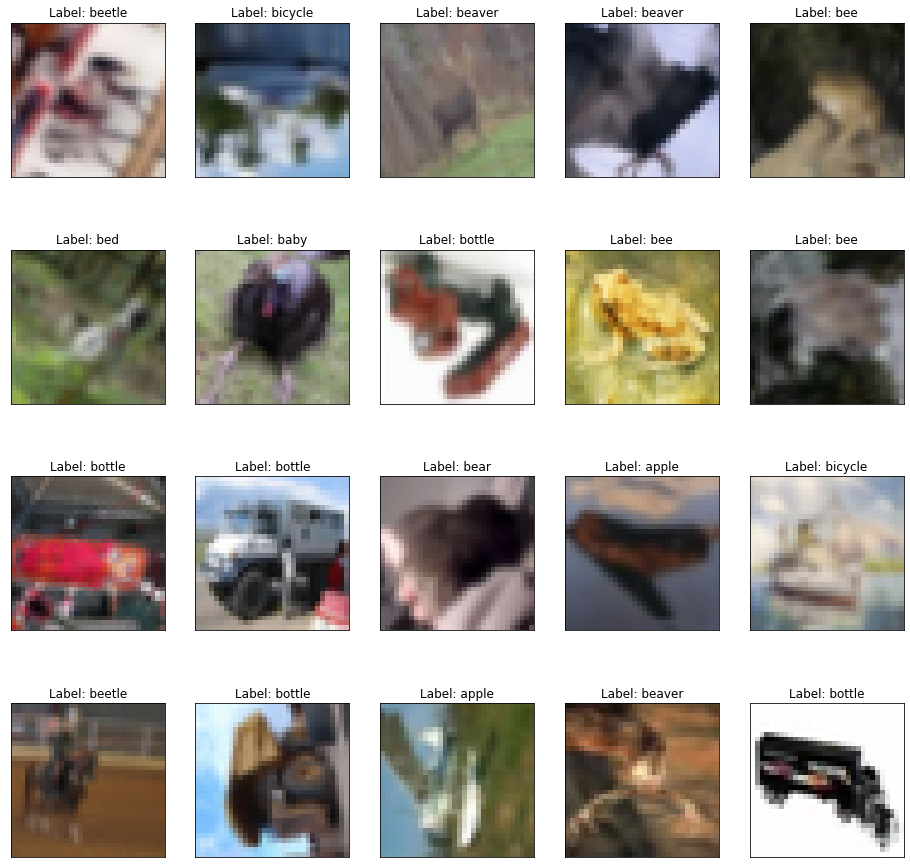

In [11]:
train_ds, test_ds = get_dataset('cifar10')
view_image(train_ds)

In [12]:
relu_lenet5_model = build_lenet_5(activation_f='relu')
relu_lenet5_model_history, relu_lenet5_model = train_model(model_name='cifar_10-relu_lenet_5', model=relu_lenet5_model, train=train_ds, test=test_ds)

In [13]:
tanh_lenet5_model = build_lenet_5(activation_f='tanh')
tanh_lenet5_model_history, tanh_lenet5_model = train_model(model_name='cifar_10-than_lenet_5', model=tanh_lenet5_model, train=train_ds, test=test_ds)

In [14]:
NUM_CLASSES = 100
train_ds, test_ds = get_dataset('cifar100')

In [15]:
relu_cifar_100_lenet5_model = build_lenet_5(activation_f='relu')
relu_cifar_100_lenet5_model_history, relu_cifar_100_lenet5_model = train_model(model_name='cifar_100-relu_lenet_5', model=relu_cifar_100_lenet5_model, train=train_ds, test=test_ds)

In [16]:
tanh_cifar_100_lenet5_model = build_lenet_5(activation_f='tanh')
tanh_cifar_100_lenet5_model_history, tanh_cifar_100_lenet5_model = train_model(model_name='cifar_100-tanh_lenet_5', model=tanh_cifar_100_lenet5_model, train=train_ds, test=test_ds)

In [17]:
train_ds, test_ds = get_dataset('cifar100', augment=False)

In [19]:
tanh_no_aug_cifar_100_lenet5_model = build_lenet_5(activation_f='tanh')
tanh_no_aug_cifar_100_lenet5_model_history, tanh_no_aug_cifar_100_lenet5_model = train_model(model_name='cifar_100-no_aug-tanh_lenet_5', model=tanh_no_aug_cifar_100_lenet5_model, train=train_ds, test=test_ds)

In [20]:
NUM_CLASSES = 10
train_ds, test_ds = get_dataset('cifar10', augment=False)

In [21]:
tanh_no_aug_cifar_10_lenet5_model = build_lenet_5(activation_f='tanh')
tanh_no_aug_cifar_10_lenet5_model_history, tanh_no_aug_cifar_10_lenet5_model = train_model(model_name='cifar_10-no_aug-tanh_lenet_5', model=tanh_no_aug_cifar_10_lenet5_model, train=train_ds, test=test_ds)

In [51]:
def plot_history(hist: dict):
    fig, ax = plt.subplots(2,1, figsize=(8, 10))

    ax[0].plot(hist['loss'], color='b', label="Training loss")
    ax[0].plot(hist['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(hist['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(hist['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)

    return fig

Выше не происходило ровно ничего интересного. Или необычного. А вот графики любопытны.

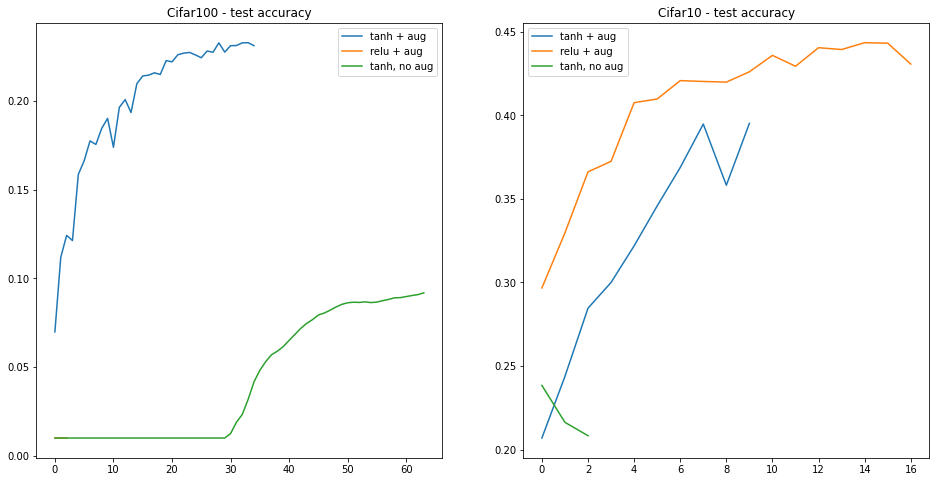

In [60]:
figure, ax = plt.subplots(1, 2, figsize=(16, 8))
axs = ax.flatten()

cifar_100_plots = [
    axs[0].plot(tanh_cifar_100_lenet5_model_history.history['val_accuracy']),
    axs[0].plot(relu_cifar_100_lenet5_model_history.history['val_accuracy']),
    axs[0].plot(tanh_no_aug_cifar_100_lenet5_model_history.history['val_accuracy'])
]
axs[0].set_title("Cifar100 - test accuracy")

cifar_10_plots = [
    axs[1].plot(tanh_lenet5_model_history.history['val_accuracy']),
    axs[1].plot(relu_lenet5_model_history.history['val_accuracy']),
    axs[1].plot(tanh_no_aug_cifar_10_lenet5_model_history.history['val_accuracy'])
]
axs[1].set_title("Cifar10 - test accuracy")

ax[0].legend(['tanh + aug', 'relu + aug', 'tanh, no aug'])
ax[1].legend(['tanh + aug', 'relu + aug', 'tanh, no aug'])

plt.show()


1. Без аугментации сетка вобще не хотела обучаться. Это интересно. Интуиция - аугментация заставляет сетку выделять наиболее важные параметры, невзирая на недостаточность архитектуры. 
2. Функция активации по-настоящему важный момент. Нельзя лепить везде ReLu. Однако на Cifar-10, где архитектура сетки хоть как-то подходит, ReLu показывает значительно лучший результат.
3. При мизерном learning rate, tanh хоть как-то начал обучаться. Так что это тоже важный параметр не только с точки зрения скорости обучения. 

Следует также упамянуть, что обучние без аугментации проходит в три раза быстрее. Так что накидывать аугментацию по принципу "чем больше, тем лучше", тоже не стоит. <br>
Я пробовал добавлять аугментацию по цветам и каналам - скорость (в смысле производительности железа) обучения вобще никакая. И тут оно не нужно.

**Заключение**

В ML нет ничего стандартного. Всё нужно понимать и пробовать. Конечно, есть некоторые best practicies, но это скорее отправная точка. <br>
Занимаясь ML чувствуешь себя колонистом на другой планете, каждый день что-то новое и это замечательно.